In [2]:
%pip install standard-precip

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import geopandas as gpd
from scipy.stats import gamma, norm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path
import sys

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))

from standard_precip.spi import SPI
from standard_precip.utils import plot_index

In [4]:
input_data =  project_root / 'data' / 'output_data'/'modelled_data_snowdrought'/'onset_to_peak_data.csv'
output_path = project_root / 'data' / 'output_data'/'SPI//'
shapefile_path = project_root / 'data' / 'input_data' /'Elevation'/'Bow_elevation_combined.shp'

In [5]:
# Open shape file
bow_basin = gpd.read_file(shapefile_path)
display(bow_basin.head())

,PROVCD_1,VALDATE,EDITION,DATASETNAM,VERSION,COMPLEVEL,WSCMDA,WSCSDA,WSCSSDA,FDA,...,WSCSSDANAM,min,max,mean,count,std,median,PROVCD_2,elev_class,geometry
0,AB,20070208,1,05BM000,0,NHN-CL1,05,05B,05BM,05BM,...,Lower Bow - Crowfoot,776.0,1177.0,953.688214,9897452,71.132927,944.0,NaN,500_1000m,"POLYGON ((-112.58577 51.23024, -112.58519 51.2..."
1,AB,20070130,1,05BN000,0,NHN-CL1,05,05B,05BN,05BN,...,Lower Bow - Mouth,700.0,998.0,772.376015,9312616,32.852467,764.0,NaN,500_1000m,"POLYGON ((-112.49620 50.71881, -112.49566 50.7..."
2,AB,20070226,1,05BH000,0,NHN-CL1,05,05B,05BH,05BH,...,Central Bow - Jumpingpond,1038.0,2479.0,1259.913722,4121228,176.434021,1227.0,NaN,1000_1500m,"POLYGON ((-113.93263 51.12563, -113.93288 51.1..."
3,AB,20070228,1,05BK000,0,NHN-CL1,05,05B,05BK,05BK,...,Fish (Alta.),981.0,1777.0,1226.170423,1151005,126.086335,1194.0,NaN,1000_1500m,"POLYGON ((-114.10188 50.95504, -114.09750 50.9..."
4,AB,20070302,1,05BE000,0,NHN-CL1,05,05B,05BE,05BE,...,Upper Bow - Policeman,1146.0,3054.0,1601.837836,1655101,376.052387,1437.0,NaN,1500_2000m,"POLYGON ((-114.72215 51.33033, -114.72235 51.3..."


In [6]:
rainfall_data = pd.read_csv(input_data)
rainfall_data.set_index('time', inplace=True)

display(rainfall_data.head())

,Grid_id,lon,lat,SWE,Precipitation,Elevation_Category,Season_year,daily_SWE_change
time,,,,,,,,
1981-02-11,1,-116.13797,51.33459,152.250,0.000000,2000_2500m,1980,0.570312
1980-11-07,1,-116.13797,51.33459,27.000,2.128011,2000_2500m,1980,0.000000
1980-12-21,1,-116.13797,51.33459,110.625,3.271602,2000_2500m,1980,0.000000
1980-10-25,1,-116.13797,51.33459,12.625,0.000000,2000_2500m,1980,27.875000
1980-11-13,1,-116.13797,51.33459,40.500,0.007695,2000_2500m,1980,13.000000


In [7]:
# remove lat, lon and SWE columns if they exist
rainfall_data = rainfall_data.drop(columns=['lat', 'lon', 'SWE','daily_SWE_change','cumulative_P'], errors='ignore')

# Rename columns if needed (update based on your actual header)
rainfall_data.columns = [col.strip() for col in rainfall_data.columns]
# The index may not be datetime yet, so convert it first
rainfall_data.index = pd.to_datetime(rainfall_data.index)

# The index is now datetime, so we can just assign it to a new column if needed
rainfall_data['Date'] = rainfall_data.index

# Filter for Oct–May only
rainfall_data = rainfall_data[rainfall_data.index.month.isin([10, 11, 12, 1, 2, 3, 4, 5])]

display(rainfall_data.head())

,Grid_id,Precipitation,Elevation_Category,Season_year,Date
time,,,,,
1981-02-11,1,0.000000,2000_2500m,1980,1981-02-11
1980-11-07,1,2.128011,2000_2500m,1980,1980-11-07
1980-12-21,1,3.271602,2000_2500m,1980,1980-12-21
1980-10-25,1,0.000000,2000_2500m,1980,1980-10-25
1980-11-13,1,0.007695,2000_2500m,1980,1980-11-13


In [8]:
# Calculate monthly precipitation for each season year and grid point
monthly_precip = (
    rainfall_data
    .groupby(['Grid_id', 'Season_year', pd.Grouper(key='Date', freq='M')])['Precipitation']
    .sum()
    .reset_index()
)

# Add elevation category for each Grid_id
# Get unique mapping from Grid_id to Elevation_Category
elevation_map = rainfall_data[['Grid_id', 'Elevation_Category']].drop_duplicates().set_index('Grid_id')['Elevation_Category']
monthly_precip['Elevation_Category'] = monthly_precip['Grid_id'].map(elevation_map)

display(monthly_precip.head())

,Grid_id,Season_year,Date,Precipitation,Elevation_Category
0,1,1980,1980-10-31,9.161071,2000_2500m
1,1,1980,1980-11-30,50.295086,2000_2500m
2,1,1980,1980-12-31,108.955549,2000_2500m
3,1,1980,1981-01-31,13.916898,2000_2500m
4,1,1980,1981-02-28,38.431036,2000_2500m


In [9]:
# Calculate monthly average precipitation for each Elevation_Category, Season_year, and month
monthly_avg = (
    monthly_precip
    .groupby(['Elevation_Category', 'Season_year', monthly_precip['Date']])['Precipitation']
    .mean()
    .unstack(level=0)  # Elevation_Category as columns
)

# Rename columns to match the format "2000-2500m_P"
monthly_avg.columns = [f"{col}_P" for col in monthly_avg.columns]

display(monthly_avg.head(10))

1000_1500m_P  1500_2000m_P  2000_2500m_P  500_1000m_P
Season_year Date                                                             
1980        1980-10-31     11.278646     23.107287     16.283314     6.029624
            1980-11-30     23.173287     32.786186     52.304052    12.598151
            1980-12-31     15.068457     33.435977     94.355993    17.063118
            1981-01-31      9.967167     10.810990     11.316449    11.567617
            1981-02-28      8.874055     13.449608     29.459216     2.885608
            1981-03-31      9.372507     10.285527     14.930461          NaN
            1981-04-30     11.146534     15.148091     28.866890          NaN
            1981-05-31     94.505921     93.067019     60.196373          NaN
1981        1981-10-31     15.946284     13.428639     33.749206     8.283148
            1981-11-30      4.466762      6.709451     12.219782     7.166000

In [10]:
# Save the combined data to a CSV file
#monthly_avg.to_csv(output_path + 'monthly_precipitation.csv')


In [11]:
# Group by season and sum the precipitation for each column
seasonal_precip = monthly_avg.groupby('Season_year').sum(numeric_only=True)

display(seasonal_precip)


,1000_1500m_P,1500_2000m_P,2000_2500m_P,500_1000m_P
Season_year,,,,
1980,183.386574,232.090686,307.712748,50.144119
1981,108.039912,118.250639,249.130062,86.981536
1982,77.440414,113.179815,185.592117,66.073298
1983,32.734949,171.032890,213.118394,54.822217
1984,93.088361,141.939992,207.965579,75.855398
1985,157.692104,206.002977,306.397238,49.548402
1986,67.633892,100.343192,202.945196,58.452687
1987,54.421573,182.154022,199.179332,43.789924
1988,85.434439,147.419844,227.209128,67.098384


# General steps to calculate SPI

In [12]:
# Calculate SPI for each elevation column and season year
spi_results = {}

for col in seasonal_precip.columns:
    # Drop NaNs and non-positive values for SPI calculation
    precip = seasonal_precip[col].dropna()
    precip = precip[precip > 0]  # Only positive values
    if len(precip) < 10:  # Not enough data to fit
        spi_results[col.replace('_P', '_SPI')] = [float('nan')] * len(seasonal_precip)
        continue
    shape, loc, scale = gamma.fit(precip, floc=0)
    cdf = gamma.cdf(seasonal_precip[col], shape, loc=loc, scale=scale)
    #cdf = cdf.clip(1e-10, 1 - 1e-10)  # Avoid exactly 0 or 1
    spi = norm.ppf(cdf)
    spi_results[col.replace('_P', '_SPI')] = spi

# Combine SPI results into a DataFrame
spi_df = pd.DataFrame(spi_results, index=seasonal_precip.index)

display(spi_df.tail(20))

,1000_1500m_SPI,1500_2000m_SPI,2000_2500m_SPI,500_1000m_SPI
Season_year,,,,
2003,-1.009384,-1.893338,-0.638820,0.562241
2004,1.353033,0.216088,0.139427,-1.728956
2005,0.786382,-0.120404,0.024015,-1.054498
2006,1.506775,0.709763,1.339404,1.715594
2007,0.779815,0.361923,0.681188,0.713459
2008,-0.040674,-0.846291,-0.571629,0.482363
2009,0.878016,0.850352,-1.046763,1.495055
2010,0.406943,0.421923,0.491553,1.487997
2011,-0.323214,0.946963,1.443226,-0.504565


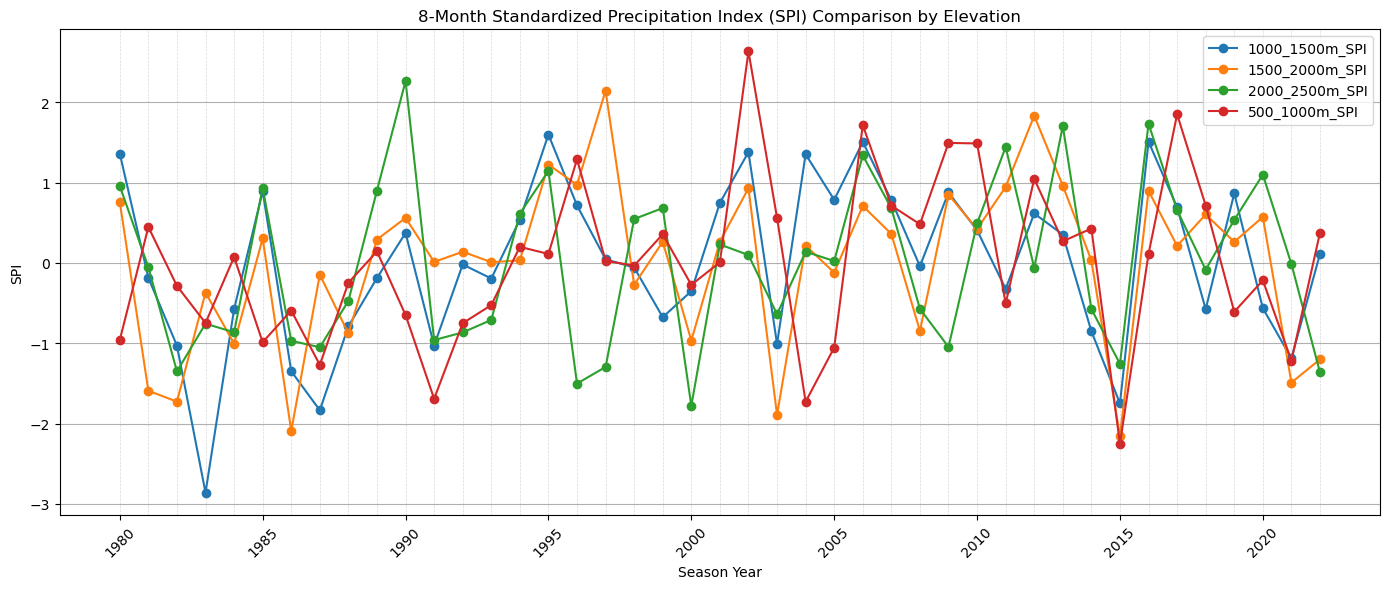

In [13]:
# Plot all SPI columns from spi_df on the same graph for comparison
plt.figure(figsize=(14, 6))
for col in spi_df.columns:
    plt.plot(spi_df.index, spi_df[col], marker='o', label=col)

plt.xlabel('Season Year')
plt.ylabel('SPI')
plt.title('8-Month Standardized Precipitation Index (SPI) Comparison by Elevation')
plt.legend()
plt.grid(True, axis='y')
for year in spi_df.index:
    plt.axvline(x=year, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
plt.xticks(
    ticks=spi_df.index[::5],  # every 5th year
    labels=spi_df.index[::5],
    rotation=45
)
plt.tight_layout()
plt.show()

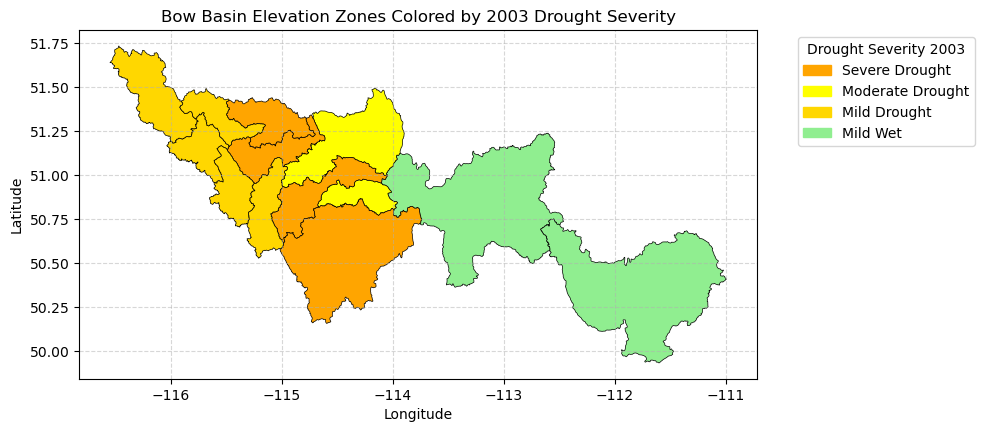

In [22]:
# Map elevation categories to SPI columns for 2003
year = 2003
df_spi_year = spi_df.loc[[year]]

# Map elevation categories to SPI columns
elev_to_spi_col = {
    '500_1000m': '500_1000m_SPI',
    '1000_1500m': '1000_1500m_SPI',
    '1500_2000m': '1500_2000m_SPI',
    '2000_2500m': '2000_2500m_SPI'
}

def get_spi_for_zone(row):
    elev_cat = row['elev_class']
    spi_col = elev_to_spi_col.get(elev_cat)
    if spi_col and spi_col in df_spi_year.columns and not df_spi_year.empty:
        return df_spi_year.iloc[0][spi_col]
    return None

bow_basin['SPI_2003'] = bow_basin.apply(get_spi_for_zone, axis=1)

def classify_spi(spi):
    if spi is None or pd.isna(spi):
        return 'Unknown'
    if spi <= -2.00:
        return 'Extreme Drought'
    elif spi <= -1.50:
        return 'Severe Drought'
    elif spi <= -1.00:
        return 'Moderate Drought'
    elif spi <= 0.00:
        return 'Mild Drought'
    elif spi <= 0.99:
        return 'Mild Wet'
    elif spi <= 1.49:
        return 'Moderately Wet'
    elif spi <= 1.99:
        return 'Severely Wet'
    else:
        return 'Extremely Wet'

bow_basin['Drought_Classification_2003'] = bow_basin['SPI_2003'].apply(classify_spi)

severity_colors = {
    'Extreme Drought': "#FF0000",
    'Severe Drought': "#FFA500",
    'Moderate Drought': "#FFFF00",
    'Mild Drought': "#FFD700",
    'Mild Wet': "#90EE90",
    'Moderately Wet': "#00FF00",
    'Severely Wet': "#00B7EB",
    'Extremely Wet': "#0000FF",
    'Unknown': "#B0B0B0",
    'Near Normal': "#FFFFFF"
}
bow_basin['color_2003'] = bow_basin['Drought_Classification_2003'].map(severity_colors)

fig, ax = plt.subplots(figsize=(10, 8))
bow_basin.plot(ax=ax, color=bow_basin['color_2003'], edgecolor='black', linewidth=0.5)
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in severity_colors.items() if label in bow_basin['Drought_Classification_2003'].unique()]
plt.legend(handles=legend_patches, title='Drought Severity 2003', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Bow Basin Elevation Zones Colored by 2003 Drought Severity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Standard_precip Workflow
(https://github.com/e-baumer/standard_precip)

In [15]:
spi = SPI()
df_spi = spi.calculate(
    monthly_avg.reset_index(),  # Use monthly_avg DataFrame
    'Date',
    '1000_1500m_P',
    freq="M",
    scale=8,
    fit_type="lmom",
    dist_type="gam"
)

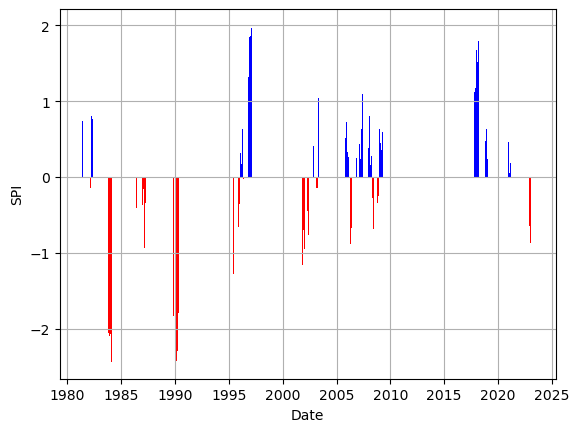

In [16]:
fig = plot_index(df_spi, 'Date', '1000_1500m_P_scale_8_calculated_index')

In [17]:
print(df_spi)

          Date  1000_1500m_P_scale_8  1000_1500m_P_scale_8_calculated_index
0   1980-10-31                   NaN                                    NaN
1   1980-11-30                   NaN                                    NaN
2   1980-12-31                   NaN                                    NaN
3   1981-01-31                   NaN                                    NaN
4   1981-02-28                   NaN                                    NaN
..         ...                   ...                                    ...
325 2022-12-31            128.754076                              -0.870763
326 2023-01-31            135.082490                              -0.606645
327 2023-02-28            136.499501                              -0.882187
328 2023-03-31            143.568161                              -0.646306
329 2023-04-30                   NaN                                    NaN

[330 rows x 3 columns]


In [18]:
# filter may 31st data
may_31st = df_spi[df_spi['Date'].dt.month == 5] 
# Display the filtered data
print(may_31st)

          Date  1000_1500m_P_scale_8  1000_1500m_P_scale_8_calculated_index
7   1981-05-31            183.386574                               0.741557
15  1982-05-31                   NaN                                    NaN
30  1984-05-31                   NaN                                    NaN
38  1985-05-31                   NaN                                    NaN
46  1986-05-31            157.692104                              -0.411687
61  1988-05-31                   NaN                                    NaN
76  1990-05-31                   NaN                                    NaN
84  1991-05-31                   NaN                                    NaN
92  1992-05-31                   NaN                                    NaN
100 1993-05-31                   NaN                                    NaN
108 1994-05-31                   NaN                                    NaN
116 1995-05-31            140.128331                              -1.274567
124 1996-05-

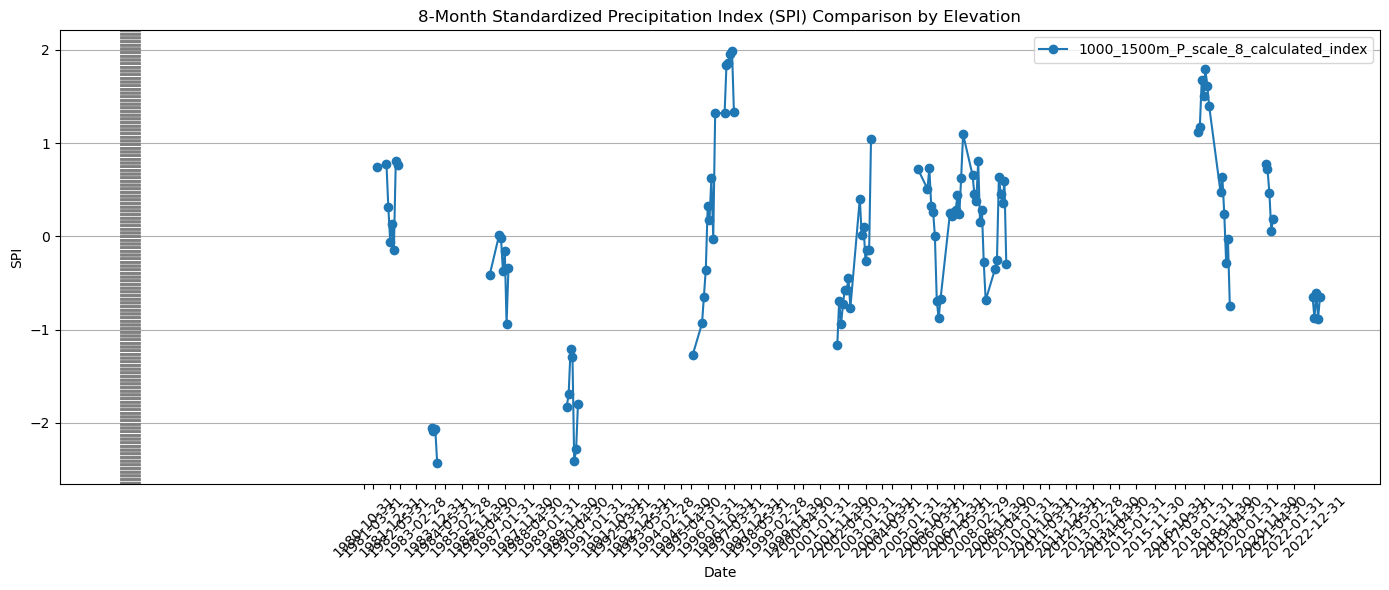

In [19]:
#plot time series
plt.figure(figsize=(14, 6))
for col in df_spi.columns:
    if col.startswith('1000_1500m_P_scale_8_calculated_index'):
        plt.plot(df_spi['Date'], df_spi[col], marker='o', label=col)
plt.xlabel('Date')
plt.ylabel('SPI')
plt.title('8-Month Standardized Precipitation Index (SPI) Comparison by Elevation')
plt.legend()
plt.grid(True, axis='y')
for year in df_spi.index:
    plt.axvline(x=year, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
plt.xticks(
    ticks=df_spi['Date'][::5],  # every 5th date
    labels=df_spi['Date'][::5].dt.strftime('%Y-%m-%d'),
    rotation=45
)
plt.tight_layout()
plt.show()